In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import linregress

In [2]:
def compute_and_print_metrics(shear1_true, shear2_true, shear1_pred, shear2_pred, method_name):
    """Compute and print RMSE, Pearson correlation, and biases for shear predictions.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_pred: Predicted shear1 values
        shear2_pred: Predicted shear2 values
        method_name: Name of the method (e.g., "NPE", "AnaCal")
    
    Returns:
        dict with computed metrics
    """
    # Compute RMSEs
    rmse1 = ((shear1_true - shear1_pred) ** 2).mean().sqrt().item()
    rmse2 = ((shear2_true - shear2_pred) ** 2).mean().sqrt().item()
    
    # Compute Pearson correlations
    pearson1 = np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1, 0]
    pearson2 = np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1, 0]
    
    # Compute biases using linear regression
    lr1 = linregress(shear1_true.flatten().cpu().numpy(), shear1_pred.flatten().cpu().numpy())
    lr2 = linregress(shear2_true.flatten().cpu().numpy(), shear2_pred.flatten().cpu().numpy())
    
    # Print results
    print(f"=== {method_name} ===")
    print(f"Shear 1: RMSE = {rmse1:.6f}, Pearson r = {pearson1:.6f}")
    print(f"         c ± 3SE = {lr1.intercept:.6f} ± {3 * lr1.intercept_stderr:.6f}, m ± 3SE = {lr1.slope - 1:.6f} ± {3 * lr1.stderr:.6f}")
    print(f"Shear 2: RMSE = {rmse2:.6f}, Pearson r = {pearson2:.6f}")
    print(f"         c ± 3SE = {lr2.intercept:.6f} ± {3 * lr2.intercept_stderr:.6f}, m ± 3SE = {lr2.slope - 1:.6f} ± {3 * lr2.stderr:.6f}\n")

In [3]:
def plot_scatterplot(shear1_true, shear2_true, shear1_pred, shear2_pred, color, ylabel_template, n_display=1000, seed=0, save_path=None):
    """Create 2-panel scatterplot of true vs predicted shear.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_pred: Predicted shear1 values
        shear2_pred: Predicted shear2 values
        color: Color for scatter points
        ylabel_template: Template for y-axis label (e.g., "Posterior mean $\\gamma_{i}$" or "$\\widehat{{\\gamma}}_{i}$")
        n_display: Number of points to display
        seed: Random seed for sample selection
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    alpha = 0.25
    s = 10
    axmin = -0.06
    axmax = 0.06

    np.random.seed(seed)
    n_samples = len(shear1_true)
    indexes = np.random.choice(n_samples, n_display, replace=False)

    # Shear 1
    _ = ax[0].scatter(
        shear1_true[indexes].flatten().cpu().numpy(),
        shear1_pred[indexes].flatten().cpu().numpy(),
        color=color,
        alpha=alpha,
        s=s,
        zorder=1,
    )
    _ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)
    _ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
    _ = ax[0].set_ylabel(ylabel_template.format(i=1), fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    # Shear 2
    _ = ax[1].scatter(
        shear2_true[indexes].flatten().cpu().numpy(),
        shear2_pred[indexes].flatten().cpu().numpy(),
        color=color,
        alpha=alpha,
        s=s,
        zorder=1,
    )
    _ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)
    _ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
    _ = ax[1].set_ylabel(ylabel_template.format(i=2), fontsize=fontsize)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)
        _ = a.set_xlim(axmin, axmax)
        _ = a.set_ylim(axmin, axmax)
        _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

    fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

### **Setting 1**

**Load ground truth and NPE posterior means:**

In [4]:
setting1_npe = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

shear1_true = setting1_npe["shear1_true"]
shear2_true = setting1_npe["shear2_true"]
shear1_npe = setting1_npe["shear1_posteriormean"]
shear2_npe = setting1_npe["shear2_posteriormean"]

In [5]:
setting1_anacal = torch.load("anacal_results_setting1.pt", weights_only=False)
e1_avg = setting1_anacal["e1_sum"] / setting1_anacal["num_detections"]
e2_avg = setting1_anacal["e2_sum"] / setting1_anacal["num_detections"]
R1 = setting1_anacal["e1g1_sum"].sum() / setting1_anacal["num_detections"].sum()
R2 = setting1_anacal["e2g2_sum"].sum() / setting1_anacal["num_detections"].sum()
shear1_anacal = torch.tensor(e1_avg / R1)
shear2_anacal = torch.tensor(e2_avg / R2)

In [6]:
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_anacal, shear2_anacal, "AnaCal")

=== NPE ===
Shear 1: RMSE = 0.001076, Pearson r = 0.997474
         c ± 3SE = -0.000098 ± 0.000031, m ± 3SE = -0.018554 ± 0.002097
Shear 2: RMSE = 0.001148, Pearson r = 0.997207
         c ± 3SE = 0.000091 ± 0.000034, m ± 3SE = -0.015408 ± 0.002213

=== AnaCal ===
Shear 1: RMSE = 0.006244, Pearson r = 0.920805
         c ± 3SE = -0.000047 ± 0.000187, m ± 3SE = -0.004966 ± 0.012645
Shear 2: RMSE = 0.007793, Pearson r = 0.912232
         c ± 3SE = -0.003831 ± 0.000204, m ± 3SE = -0.005578 ± 0.013399



**Plot true versus predicted shear:**

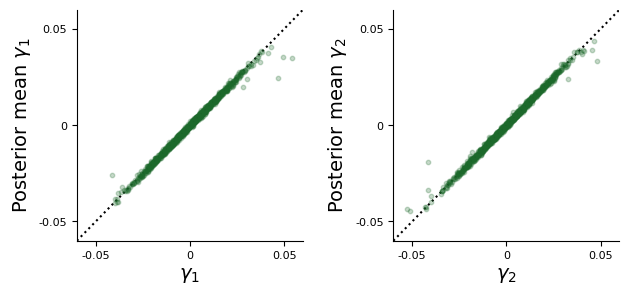

In [7]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting1.png"
)

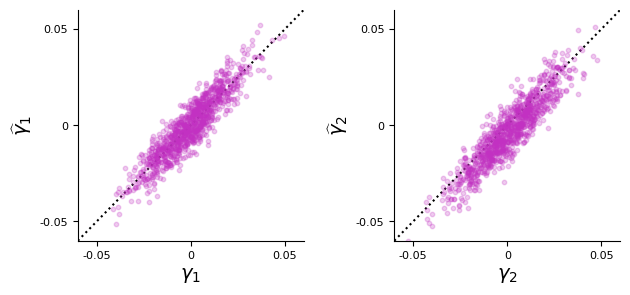

In [8]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_anacal, shear2_anacal,
    color="#c231c2",
    ylabel_template=r"$\widehat{{\gamma}}_{i}$",
    save_path="figures/anacal_scatterplots_setting1.png"
)

### **Setting 2**

In [9]:
setting2_npe = torch.load("npe_credible_intervals_setting2.pt", weights_only=False)

shear1_true = setting2_npe["shear1_true"]
shear2_true = setting2_npe["shear2_true"]
shear1_npe = setting2_npe["shear1_posteriormean"]
shear2_npe = setting2_npe["shear2_posteriormean"]

setting2_anacal = torch.load("anacal_results_setting2.pt", weights_only=False)
e1_avg = setting2_anacal["e1_sum"] / setting2_anacal["num_detections"]
e2_avg = setting2_anacal["e2_sum"] / setting2_anacal["num_detections"]
R1 = setting2_anacal["e1g1_sum"].sum() / setting2_anacal["num_detections"].sum()
R2 = setting2_anacal["e2g2_sum"].sum() / setting2_anacal["num_detections"].sum()
shear1_anacal = torch.tensor(e1_avg / R1)
shear2_anacal = torch.tensor(e2_avg / R2)

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_anacal, shear2_anacal, "AnaCal")

=== NPE ===
Shear 1: RMSE = 0.000975, Pearson r = 0.997956
         c ± 3SE = -0.000025 ± 0.000028, m ± 3SE = -0.016583 ± 0.001889
Shear 2: RMSE = 0.001098, Pearson r = 0.997368
         c ± 3SE = 0.000018 ± 0.000032, m ± 3SE = -0.016532 ± 0.002145

=== AnaCal ===
Shear 1: RMSE = 0.007310, Pearson r = 0.904511
         c ± 3SE = 0.001073 ± 0.000217, m ± 3SE = 0.023720 ± 0.014481
Shear 2: RMSE = 0.007574, Pearson r = 0.892900
         c ± 3SE = -0.000210 ± 0.000227, m ± 3SE = 0.003649 ± 0.015185



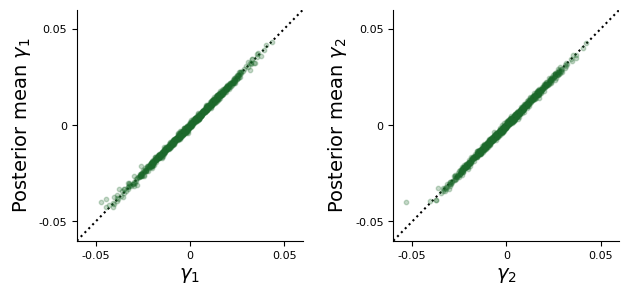

In [10]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting2.png"
)

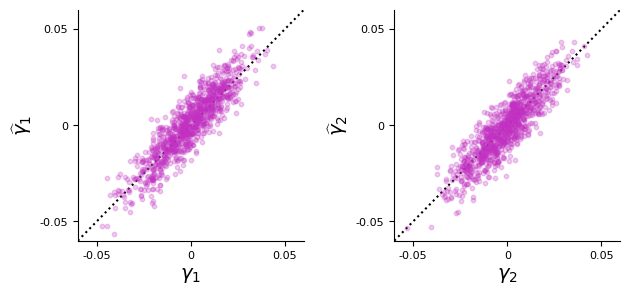

In [11]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_anacal, shear2_anacal,
    color="#c231c2",
    ylabel_template=r"$\widehat{{\gamma}}_{i}$",
    save_path="figures/anacal_scatterplots_setting2.png"
)

### **Setting 3**

In [12]:
setting3_npe = torch.load("npe_credible_intervals_setting3.pt", weights_only=False)

shear1_true = setting3_npe["shear1_true"]
shear2_true = setting3_npe["shear2_true"]
shear1_npe = setting3_npe["shear1_posteriormean"]
shear2_npe = setting3_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.001948, Pearson r = 0.992862
         c ± 3SE = -0.000708 ± 0.000051, m ± 3SE = -0.040869 ± 0.003457
Shear 2: RMSE = 0.002069, Pearson r = 0.991104
         c ± 3SE = -0.000388 ± 0.000058, m ± 3SE = -0.044691 ± 0.003849



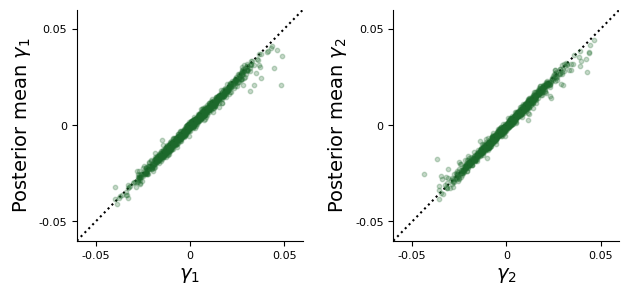

In [13]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting3.png"
)

### **Setting 4**

In [14]:
setting4_npe = torch.load("npe_credible_intervals_setting4.pt", weights_only=False)

shear1_true = setting4_npe["shear1_true"]
shear2_true = setting4_npe["shear2_true"]
shear1_npe = setting4_npe["shear1_posteriormean"]
shear2_npe = setting4_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.002092, Pearson r = 0.990732
         c ± 3SE = 0.000419 ± 0.000061, m ± 3SE = -0.023513 ± 0.004017
Shear 2: RMSE = 0.001959, Pearson r = 0.991667
         c ± 3SE = 0.000126 ± 0.000059, m ± 3SE = 0.009815 ± 0.003936



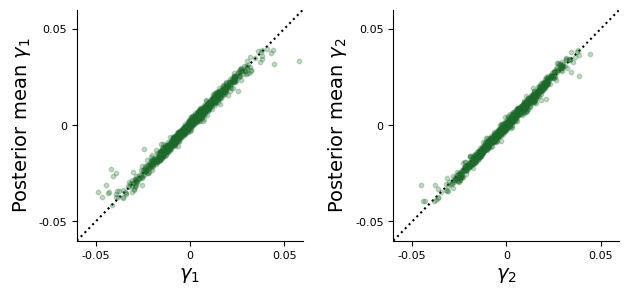

In [15]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting4.png"
)

### **Setting 5**

In [16]:
setting5_npe = torch.load("npe_credible_intervals_setting5.pt", weights_only=False)

shear1_true = setting5_npe["shear1_true"]
shear2_true = setting5_npe["shear2_true"]
shear1_npe = setting5_npe["shear1_posteriormean"]
shear2_npe = setting5_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.001872, Pearson r = 0.992426
         c ± 3SE = 0.000338 ± 0.000054, m ± 3SE = -0.025357 ± 0.003620
Shear 2: RMSE = 0.001974, Pearson r = 0.992137
         c ± 3SE = 0.000272 ± 0.000054, m ± 3SE = -0.051415 ± 0.003590



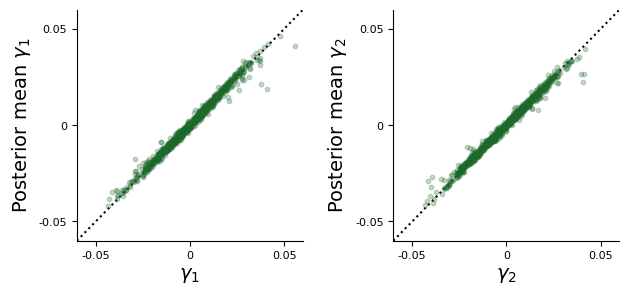

In [17]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting5.png"
)

### **LaTeX Table**

In [18]:
def compute_metrics(shear1_true, shear2_true, shear1_pred, shear2_pred):
    """Compute m, RMSE, and Pearson r for both shear components."""
    rmse1 = ((shear1_true - shear1_pred) ** 2).mean().sqrt().item()
    rmse2 = ((shear2_true - shear2_pred) ** 2).mean().sqrt().item()
    
    pearson1 = np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1, 0]
    pearson2 = np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1, 0]
    
    lr1 = linregress(shear1_true.flatten().cpu().numpy(), shear1_pred.flatten().cpu().numpy())
    lr2 = linregress(shear2_true.flatten().cpu().numpy(), shear2_pred.flatten().cpu().numpy())
    
    m1 = lr1.slope - 1
    m2 = lr2.slope - 1
    m1_se = lr1.stderr
    m2_se = lr2.stderr
    
    return {
        "g1": {"m": m1, "m_se": m1_se, "rmse": rmse1, "pearson": pearson1},
        "g2": {"m": m2, "m_se": m2_se, "rmse": rmse2, "pearson": pearson2},
    }

# Collect all metrics
results = {}

for setting in range(1, 6):
    results[setting] = {}
    
    # Load NPE data
    npe_data = torch.load(f"npe_credible_intervals_setting{setting}.pt", weights_only=False)
    shear1_true = npe_data["shear1_true"]
    shear2_true = npe_data["shear2_true"]
    shear1_npe = npe_data["shear1_posteriormean"]
    shear2_npe = npe_data["shear2_posteriormean"]
    results[setting]["npe"] = compute_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe)
    
    # Load AnaCal data (only available for settings 1-2)
    if setting <= 2:
        anacal_data = torch.load(f"anacal_results_setting{setting}.pt", weights_only=False)
        e1_avg = anacal_data["e1_sum"] / anacal_data["num_detections"]
        e2_avg = anacal_data["e2_sum"] / anacal_data["num_detections"]
        R1 = anacal_data["e1g1_sum"].sum() / anacal_data["num_detections"].sum()
        R2 = anacal_data["e2g2_sum"].sum() / anacal_data["num_detections"].sum()
        shear1_anacal = torch.tensor(e1_avg / R1)
        shear2_anacal = torch.tensor(e2_avg / R2)
        results[setting]["anacal"] = compute_metrics(shear1_true, shear2_true, shear1_anacal, shear2_anacal)
    else:
        results[setting]["anacal"] = None

# Generate LaTeX table
def fmt(val, decimals=3):
    """Format a number with specified decimals."""
    return f"{val:.{decimals}f}"

def fmt_m_with_se(m, se, decimals=3):
    """Format m with standard error as m (SE)."""
    return f"{fmt(m, decimals)} ({fmt(se, decimals)})"

latex_lines = []
latex_lines.append(r"\begin{tabular}{ll ccc ccc}")
latex_lines.append(r"    \toprule")
latex_lines.append(r"    & & \multicolumn{3}{c}{\textbf{AnaCal}} & \multicolumn{3}{c}{\textbf{NPE}} \\")
latex_lines.append(r"    \cmidrule(r){3-5} \cmidrule(l){6-8}")
latex_lines.append(r"    & & $m$ (SE) & RMSE & Pearson $r$ & $m$ (SE) & RMSE & Pearson $r$ \\")
latex_lines.append(r"    \midrule")

for setting in range(1, 6):
    npe = results[setting]["npe"]
    anacal = results[setting]["anacal"]
    
    # Format AnaCal values
    if anacal is not None:
        anacal_g1 = f"{fmt_m_with_se(anacal['g1']['m'], anacal['g1']['m_se'])} & {fmt(anacal['g1']['rmse'], 4)} & {fmt(anacal['g1']['pearson'])}"
        anacal_g2 = f"{fmt_m_with_se(anacal['g2']['m'], anacal['g2']['m_se'])} & {fmt(anacal['g2']['rmse'], 4)} & {fmt(anacal['g2']['pearson'])}"
    else:
        anacal_g1 = "--- & --- & ---"
        anacal_g2 = "--- & --- & ---"
    
    # Format NPE values
    npe_g1 = f"{fmt_m_with_se(npe['g1']['m'], npe['g1']['m_se'])} & {fmt(npe['g1']['rmse'], 4)} & {fmt(npe['g1']['pearson'])}"
    npe_g2 = f"{fmt_m_with_se(npe['g2']['m'], npe['g2']['m_se'])} & {fmt(npe['g2']['rmse'], 4)} & {fmt(npe['g2']['pearson'])}"
    
    latex_lines.append(f"    \\multirow{{2}}{{*}}{{Setting {setting}}} & $\\gamma_1$ & {anacal_g1} & {npe_g1} \\\\")
    latex_lines.append(f"                               & $\\gamma_2$ & {anacal_g2} & {npe_g2} \\\\")
    
    if setting < 5:
        latex_lines.append(r"    \midrule")

latex_lines.append(r"    \bottomrule")
latex_lines.append(r"\end{tabular}")

print("\n".join(latex_lines))

\begin{tabular}{ll ccc ccc}
    \toprule
    & & \multicolumn{3}{c}{\textbf{AnaCal}} & \multicolumn{3}{c}{\textbf{NPE}} \\
    \cmidrule(r){3-5} \cmidrule(l){6-8}
    & & $m$ (SE) & RMSE & Pearson $r$ & $m$ (SE) & RMSE & Pearson $r$ \\
    \midrule
    \multirow{2}{*}{Setting 1} & $\gamma_1$ & -0.005 (0.004) & 0.0062 & 0.921 & -0.019 (0.001) & 0.0011 & 0.997 \\
                               & $\gamma_2$ & -0.006 (0.004) & 0.0078 & 0.912 & -0.015 (0.001) & 0.0011 & 0.997 \\
    \midrule
    \multirow{2}{*}{Setting 2} & $\gamma_1$ & 0.024 (0.005) & 0.0073 & 0.905 & -0.017 (0.001) & 0.0010 & 0.998 \\
                               & $\gamma_2$ & 0.004 (0.005) & 0.0076 & 0.893 & -0.017 (0.001) & 0.0011 & 0.997 \\
    \midrule
    \multirow{2}{*}{Setting 3} & $\gamma_1$ & --- & --- & --- & -0.041 (0.001) & 0.0019 & 0.993 \\
                               & $\gamma_2$ & --- & --- & --- & -0.045 (0.001) & 0.0021 & 0.991 \\
    \midrule
    \multirow{2}{*}{Setting 4} & $\gamma_1$ & --- & --- 